# Numerics for the SYK quantum batteries

let us start by including the relevant packages

In [1]:
include("/home/dario/Documents/ChargingPower/src/ChargingPower.jl")
using .ChargingPower

In [ ]:
using SparseArrays
using KrylovKit
using ExponentialUtilities
using Graphs
using Plots
using Statistics
using SpecialFunctions
using QuadGK

and let us set the parameters for the time evolution

In [3]:
min_t = 10^-2 
max_t = 10^2
number_of_points = 10^3
points = exp.(log(min_t):((log(max_t) - log(min_t)) / (number_of_points - 1)):log(max_t))

999-element Vector{Float64}:
  0.010000000000000004
  0.010092621909870477
  0.010186101701559765
  0.0102804473209331
  0.01037566678745186
  0.010471768194855211
  0.010568759711848048
  0.010666649582795396
  0.010765446128423155
  0.010865157746525389
  ⋮
 92.03731996618232
 92.889787201645
 93.75015015145291
 94.6184819472201
 95.49485639791966
 96.37934799615793
 97.27203192450553
 98.17298406188837
 99.08228099003803

## The Z-model charging power

Let us first collect the data for the Z-model battery

In [18]:
n_majorana = 28
samples_done = 0
average_energy_list = zeros(Float64, length(points) - 1)
e_0 = -n_majorana /2

-14.0

In [ ]:
n_samples = 1
energy_single_size_list = Array{Float64}[] 
majorana_matrices = majorana_operators(n_majorana)
graph = complete_graph(n_majorana)
battery_hamiltonian = Z_model_hamiltonian(majorana_matrices)
for i in 1:n_samples 
    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
    e_0 = real(ground_state_rough[1][1])
    ground_state = ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index != length(points)
            ground_state = expv(- im * (points[index + 1] - points[index]), charging_hamiltonian, ground_state)
            push!(energy_list, real(ground_state' * battery_hamiltonian * ground_state))
        end
    end
    push!(energy_single_size_list, energy_list)
end
average_energy_list = (samples_done .* average_energy_list + n_samples * mean(energy_single_size_list)) / (samples_done + n_samples)
samples_done += n_samples
samples_done


1

In [20]:
# average_power_list = [((average_energy_list[index] - e_0))/(points[index]) for index in 1:(length(points) - 1)]
# theoretical_points = [(n_majorana/2) * (1/t) * (1 - 1.0 * (besselj(1,  2.0*t) / t)^2) for t in points[2:length(points)]]
theoretical_points = [-(n_majorana/2) * (besselj(1,  2.0*t) / t)^2 for t in points[2:length(points)]]

999-element Vector{Float64}:
 -13.858648719088958
 -13.856688771899496
 -13.854701767404874
 -13.852687335408557
 -13.850645100742579
 -13.848574683203443
 -13.846475697487229
 -13.84434775312398
 -13.842190454411297
 -13.840003400347182
   ⋮
  -9.279898020373937e-9
  -4.703471601713468e-6
  -1.3718041339290543e-6
  -2.459296135955136e-6
  -3.507676154896373e-6
  -5.029518894881962e-7
  -4.578441817116541e-6
  -3.0532504887852895e-8
  -4.128576014082118e-6

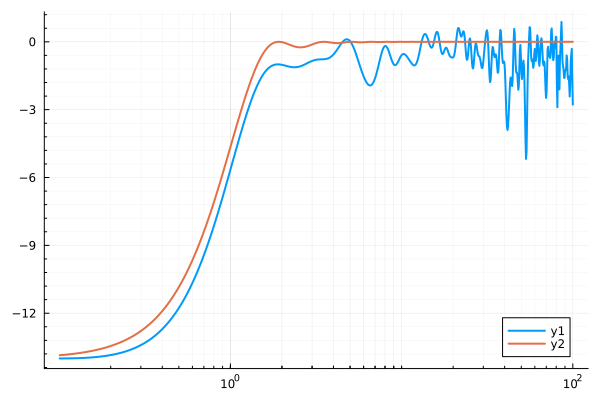

In [22]:
plot(points[2: length(points)], [average_energy_list, theoretical_points], xaxis=:log, linewidth=2, minorgrid=true)   

## The X-model charging power

Let us now collect the data for the X-model battery

In [17]:
n_majorana = 28
samples_done = 0
average_energy_list = zeros(Float64, length(points))
e_0 = -n_majorana /2

-14.0

In [57]:
n_samples = 1
energy_single_size_list = Array{Float64}[] 
majorana_matrices = majorana_operators(n_majorana)
graph = complete_graph(n_majorana)
battery_hamiltonian = X_model_hamiltonian(majorana_matrices)
for i in 1:n_samples 
    charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)
    ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
    e_0 = real(ground_state_rough[1][1])
    ground_state = ground_state_rough[2][1]
    energy_list = Float64[]
    for index in eachindex(points) 
        if index == 1
            ground_state = expv(- im * points[index], charging_hamiltonian, ground_state)
        else
            ground_state = expv(- im * (points[index] - points[index-1]), charging_hamiltonian, ground_state)
        end
        push!(energy_list, (real(ground_state' * battery_hamiltonian * ground_state)))
    end
    push!(energy_single_size_list, energy_list)
end
average_energy_list = (samples_done .* average_energy_list + n_samples * mean(energy_single_size_list)) / (samples_done + n_samples)
samples_done += n_samples
samples_done


10

In [ ]:
theoretical_points = Float64[]
for t in points
    sum = 0.0 
    for k in 1:floor(Int, n_majorana/2)
        sum += (besselj(1, 2 * t * sqrt(1 - (2 * k - 1)/n_majorana)) / (t * sqrt(1 - (2 * k - 1)/n_majorana)))^(2 * k - 1)
    end
    push!(theoretical_points,  - 1 * sum)
end
average_power_list = [((average_energy_list[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_points = [((theoretical_points[index] - e_0))/(points[index]) for index in 1:length(points)]
theoretical_power_approx_points = Float64[]
for t in points
    f(x) = exp(- (1/2) * n_majorana * t^2 * x * (1 - x))
    f_value = quadgk(f, 0, 1, rtol=1e-3)[1]
    push!(theoretical_power_approx_points,  (n_majorana / t) * (1 - f_value))
end

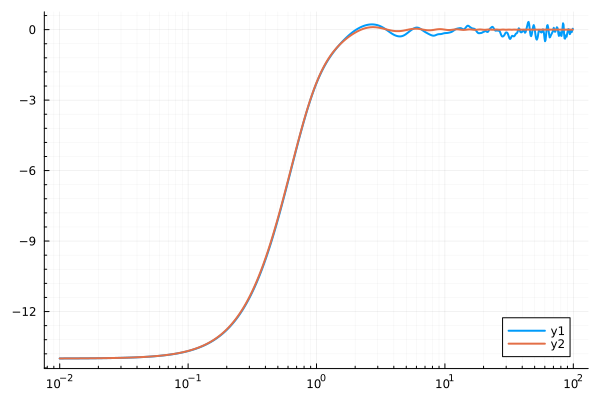

In [59]:
plot(points, [average_energy_list, theoretical_points], xaxis=:log, linewidth=2, minorgrid=true)   

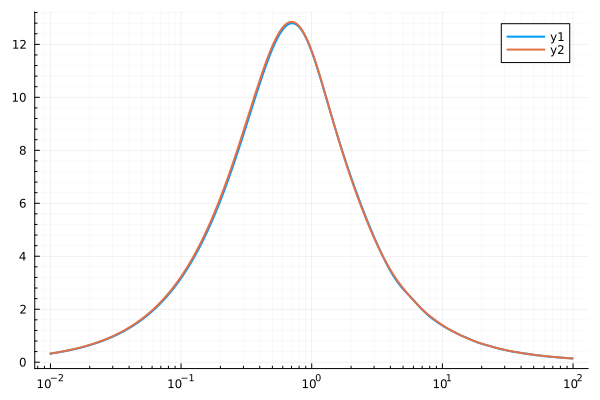

In [60]:
plot(points, [average_power_list, theoretical_power_points], xaxis=:log, linewidth=2, minorgrid=true)   